In [1]:
import pandas as pd
import numpy as np

users = pd.read_csv(
    "users.csv",
    parse_dates=["signup_date"],
    keep_default_na=False,        # do NOT auto-convert 'NA', 'N/A', etc. to NaN
    na_values=["", " ", "NaN"]    # still treat true blanks as missing
)

# (optional) normalise/spaces -> NA
users = users.apply(
    lambda s: s.replace(r"^\s*$", pd.NA, regex=True) if s.dtype == "object" else s
)

# sanity check
print(users["region"].value_counts(dropna=False))
print("Missing % in region:", users["region"].isna().mean())

region
NA       38224
APAC     27810
EU       25960
LATAM     8006
Name: count, dtype: int64
Missing % in region: 0.0


In [2]:
import pandas as pd

# Helper: keep "NA" literal, but treat blanks and "N/A" as missing
NA_SAFE = dict(
    keep_default_na=False,                 # don't auto-convert "NA"/"na" to NaN
    na_values=["", " ", "NaN", "nan", "N/A", "n/a"]  # still treat true blanks & "N/A" as NaN
)

# Load CSVs (dates parsed as before)
users    = pd.read_csv("users.csv", parse_dates=["signup_date"], **NA_SAFE)
sessions = pd.read_csv("sessions.csv", parse_dates=["session_start", "session_end"], **NA_SAFE)
events   = pd.read_csv("events.csv", parse_dates=["ts"], **NA_SAFE)
billing  = pd.read_csv("billing.csv", parse_dates=["month"], **NA_SAFE)

# -----------------------------
# Quick info and missing values
# -----------------------------
for df_name, df in zip(["users", "sessions", "events", "billing"], [users, sessions, events, billing]):
    print(f"\n=== {df_name.upper()} INFO ===")
    df.info()
    print("\nMissing values per column:")
    print(df.isna().sum())



=== USERS INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   user_id              100000 non-null  object        
 1   signup_date          100000 non-null  datetime64[ns]
 2   plan_tier            100000 non-null  object        
 3   company_size         100000 non-null  object        
 4   region               100000 non-null  object        
 5   industry             100000 non-null  object        
 6   acquisition_channel  100000 non-null  object        
 7   is_enterprise        100000 non-null  bool          
 8   churned_30d          100000 non-null  int64         
 9   churned_90d          100000 non-null  int64         
 10  downgraded           100000 non-null  int64         
 11  expansion_event      100000 non-null  int64         
dtypes: bool(1), datetime64[ns](1), int64(4), object(6)
me

In [3]:
# Optional: convert whitespace-only strings to NA across object columns (safety net)
for df in (users, sessions, events, billing):
    obj_cols = df.select_dtypes(include="object").columns
    df[obj_cols] = df[obj_cols].replace(r"^\s*$", pd.NA, regex=True)

# -----------------------------
# IMPUTE APP VERSIONS
# -----------------------------
# For example, sessions may have 'app_version' column
if "app_version" in sessions.columns:
    # Fill missing app_version with a placeholder "unknown"
    sessions["app_version"] = sessions["app_version"].fillna("unknown")

# For events dataset
if "app_version" in events.columns:
    events["app_version"] = events["app_version"].fillna("unknown")

# Quick sanity check that "NA" is kept as a category, not NaN
print(users["region"].value_counts(dropna=False).head(10))
print("Missing % in region:", users["region"].isna().mean())

# Check app_version imputation
if "app_version" in sessions.columns:
    print("Sessions app_version counts:\n", sessions["app_version"].value_counts(dropna=False).head(10))
if "app_version" in events.columns:
    print("Events app_version counts:\n", events["app_version"].value_counts(dropna=False).head(10))


region
NA       38224
APAC     27810
EU       25960
LATAM     8006
Name: count, dtype: int64
Missing % in region: 0.0
Sessions app_version counts:
 app_version
1.0.0    5667
1.9.1    5666
1.3.0    5666
1.5.5    5664
1.1.3    5662
1.9.0    5658
1.8.4    5647
1.9.4    5635
1.8.5    5624
1.6.2    5611
Name: count, dtype: int64


In [4]:
# 30-day churn rate
churn_rate_30d = users["churned_30d"].mean()
print(f"30-day churn rate: {churn_rate_30d:.2%}")

# 90-day churn rate
churn_rate_90d = users["churned_90d"].mean()
print(f"90-day churn rate: {churn_rate_90d:.2%}")



30-day churn rate: 12.96%
90-day churn rate: 22.99%


In [5]:
# Aggregate sessions per user
session_stats = sessions.groupby("user_id").agg(
    sessions_count=("session_id", "count"),
    avg_session_length=("session_length_sec", "mean")
).reset_index()

# Merge with 30d + 90d churn labels
engagement = users[["user_id", "churned_30d", "churned_90d"]] \
    .merge(session_stats, on="user_id", how="left")

# Compare churned vs retained (30d)
print("Engagement by 30d churn status:\n")
print(engagement.groupby("churned_30d")[["sessions_count", "avg_session_length"]].mean())

# Compare churned vs retained (90d)
print("\nEngagement by 90d churn status:\n")
print(engagement.groupby("churned_90d")[["sessions_count", "avg_session_length"]].mean())


Engagement by 30d churn status:

             sessions_count  avg_session_length
churned_30d                                    
0                  4.864032          839.461520
1                  3.482207          839.124266

Engagement by 90d churn status:

             sessions_count  avg_session_length
churned_90d                                    
0                  5.083332          839.376957
1                  3.007022          839.632376


In [6]:
session_stats = sessions.groupby("user_id").agg(
    avg_session_length=("session_length_sec", "mean"),
    sessions_per_week=("session_id", lambda x: float(x.nunique())/4),
    active_days=("session_start", lambda x: float(x.dt.date.nunique())),
    device_diversity=("device", "nunique"),
    os_diversity=("os", "nunique")
).reset_index()

print(session_stats[["sessions_per_week"]])


       sessions_per_week
0                   0.25
1                   0.25
2                   1.00
3                   0.50
4                   1.25
...                  ...
71528               2.75
71529               2.25
71530               0.50
71531               2.25
71532               1.25

[71533 rows x 1 columns]


In [7]:
import numpy as np
import pandas as pd

# Ensure datetime
sessions = sessions.copy()
sessions["session_start"] = pd.to_datetime(sessions["session_start"])

# (Optional) de-dup in case the same session_id appears multiple times
sessions = sessions.drop_duplicates(subset=["user_id", "session_id"])

# Per-user aggregates
g = sessions.groupby("user_id")

session_stats = g.agg(
    sessions_count=("session_id", "nunique"),
    avg_session_length=("session_length_sec", "mean"),
    first_seen=("session_start", "min"),
    last_seen=("session_start", "max"),
    active_days=("session_start", lambda x: x.dt.date.nunique()),
    device_diversity=("device", "nunique"),
    os_diversity=("os", "nunique")
).reset_index()

# Compute weeks observed per user (avoid divide-by-zero for single-day users)
span_days = (session_stats["last_seen"] - session_stats["first_seen"]).dt.total_seconds() / 86400.0
weeks_observed = np.maximum(span_days / 7.0, 1/7)   # at least one day (~1/7 week)

session_stats["sessions_per_week"] = session_stats["sessions_count"] / weeks_observed

# Inspect
session_stats[["user_id", "sessions_count", "first_seen", "last_seen", "sessions_per_week"]].head()


,user_id,sessions_count,first_seen,last_seen,sessions_per_week
0,0000093e-7258-43c0-b212-ea7212795ddf,1,2025-04-04 22:01:25.065312987,2025-04-04 22:01:25.065312987,7.000000
1,0006fdbd-c35d-4c0d-a948-e8ee10f279d5,1,2025-02-12 23:47:41.761338189,2025-02-12 23:47:41.761338189,7.000000
2,0007ee13-0c60-4865-9464-914b2df654df,4,2025-03-21 12:50:37.457893086,2025-06-06 10:27:59.068288586,0.364105
3,000836d5-0777-4310-a8a5-5c857d2ea5e5,2,2024-07-15 12:25:29.926266202,2024-09-15 23:33:35.673589849,0.224129
4,0008a782-5378-45a1-b332-10c73c4296ff,5,2025-02-20 17:05:06.077705968,2025-07-06 16:15:29.456901849,0.257418


In [8]:
# Event stats per user (30D)
event_stats = events.groupby("user_id").agg(
    fail_rate=("success", lambda x: 1 - x.mean()),
    avg_latency=("latency_ms", "mean"),
    features_used=("feature_name", "nunique")
).reset_index()

exp = users[["user_id", "churned_30d"]].merge(event_stats, on="user_id", how="left")

print(exp.groupby("churned_30d")[["fail_rate", "avg_latency", "features_used"]].mean())

# Event stats per user (90D)
event_stats = events.groupby("user_id").agg(
    fail_rate=("success", lambda x: 1 - x.mean()),
    avg_latency=("latency_ms", "mean"),
    features_used=("feature_name", "nunique")
).reset_index()

exp = users[["user_id", "churned_90d"]].merge(event_stats, on="user_id", how="left")

print(exp.groupby("churned_90d")[["fail_rate", "avg_latency", "features_used"]].mean())

             fail_rate  avg_latency  features_used
churned_30d                                       
0             0.069980   258.354448        2.07476
1             0.071522   275.063462        1.82014
             fail_rate  avg_latency  features_used
churned_90d                                       
0             0.070276   255.355131       2.106863
1             0.069418   285.484804       1.734101


In [9]:
# Aggregate billing by user (30D) in percentage 
billing_stats = billing.groupby("user_id").agg(
    overdue=("invoices_overdue", "mean"),
    discount=("discount_applied", "mean"),
    avg_tickets=("support_ticket_count", "mean")
).reset_index()

bill = users[["user_id", "churned_30d"]].merge(billing_stats, on="user_id", how="left")

print(bill.groupby("churned_30d")[["overdue", "discount", "avg_tickets"]].mean())

# Aggregate billing by user (90D)
billing_stats = billing.groupby("user_id").agg(
    overdue=("invoices_overdue", "mean"),
    discount=("discount_applied", "mean"),
    avg_tickets=("support_ticket_count", "mean")
).reset_index()

bill = users[["user_id", "churned_90d"]].merge(billing_stats, on="user_id", how="left")

print(bill.groupby("churned_90d")[["overdue", "discount", "avg_tickets"]].mean())



              overdue  discount  avg_tickets
churned_30d                                 
0            0.024312  0.071200     0.497307
1            0.026551  0.047302     0.296783
              overdue  discount  avg_tickets
churned_90d                                 
0            0.023842  0.077167     0.540442
1            0.027146  0.037744     0.239792


In [10]:
# Churn by plan tier (30D)
seg_30 = users.groupby("plan_tier")["churned_30d"].mean()
print("30D churn by plan tier:\n", seg_30)

# Churn by acquisition channel (30D)
seg2_30 = users.groupby("acquisition_channel")["churned_30d"].mean()
print("30D churn by acquisition channel:\n", seg2_30)

# Churn by plan tier (90D)
seg_90 = users.groupby("plan_tier")["churned_90d"].mean()
print("90D churn by plan tier:\n", seg_90)

# Churn by acquisition channel (90D)
seg2_90 = users.groupby("acquisition_channel")["churned_90d"].mean()
print("90D churn by acquisition channel:\n", seg2_90)



30D churn by plan tier:
 plan_tier
free        0.165465
premium     0.058785
standard    0.099987
Name: churned_30d, dtype: float64
30D churn by acquisition channel:
 acquisition_channel
ads         0.137432
outbound    0.133694
partner     0.124769
seo         0.125666
Name: churned_30d, dtype: float64
90D churn by plan tier:
 plan_tier
free        0.318936
premium     0.063667
standard    0.151543
Name: churned_90d, dtype: float64
90D churn by acquisition channel:
 acquisition_channel
ads         0.236924
outbound    0.237952
partner     0.223436
seo         0.226044
Name: churned_90d, dtype: float64


In [11]:
import sklearn
from packaging import version

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline as SkPipeline
from sklearn.metrics import f1_score, classification_report, confusion_matrix

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline  # <-- imblearn Pipeline (required for SMOTE step)
from xgboost import XGBClassifier

RANDOM_STATE = 42
TEST_SIZE = 0.20
LABEL = "churned_90d"   # change to "churned_30d" if you want 30-day churn


In [12]:
y = users["churned_90d"]   # target
X = users.drop(columns=["churned_90d"])   # features

leak_cols = ["churned_30d", "churned_90d", "downgraded", "expansion_event"]
X = X.drop(columns=[c for c in leak_cols if c in X.columns])


In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline as SkPipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import lightgbm as lgb
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from packaging import version
import sklearn

estimators = [
    ("xgb", XGBClassifier(
        n_estimators=300, max_depth=5, learning_rate=0.05, subsample=0.9,
        colsample_bytree=0.9, eval_metric="logloss", random_state=RANDOM_STATE,
        n_jobs= -1,  # or set to a small integer like 4
        tree_method="hist"
    )),
    ("lgb", lgb.LGBMClassifier(
        n_estimators=400, learning_rate=0.05, subsample=0.9,
        colsample_bytree=0.9, random_state=RANDOM_STATE,
        n_jobs= -1,                 # or a small integer like 4
        class_weight="balanced",
        verbosity=-1,
        force_row_wise=True
    )),
    ("rf", RandomForestClassifier(
        n_estimators=400, max_depth=10, random_state=RANDOM_STATE,
        n_jobs=1  # <-- prevent nested parallelism
    ))
]

stack_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    passthrough=True,
    n_jobs=1   # <-- keep outer joblib layer single-threaded
)

RANDOM_STATE = 42
TEST_SIZE = 0.2

# -----------------------------
# Load data
# -----------------------------
NA_SAFE = dict(keep_default_na=False, na_values=["", " ", "NaN", "nan", "N/A", "n/a"])
users = pd.read_csv("users.csv", parse_dates=["signup_date"], **NA_SAFE)
sessions = pd.read_csv("sessions.csv", parse_dates=["session_start", "session_end"], **NA_SAFE)
events = pd.read_csv("events.csv", parse_dates=["ts"], **NA_SAFE)
billing = pd.read_csv("billing.csv", parse_dates=["month"], **NA_SAFE)

# -----------------------------
# Session features
# -----------------------------
sess_agg = sessions.groupby("user_id").agg(
    sessions_count=("session_id", "nunique"),
    sessions_days_active=("session_start", lambda x: float(pd.to_datetime(x).dt.date.nunique())),
    avg_session_length=("session_length_sec", "mean"),
    device_diversity=("device", "nunique"),
    os_diversity=("os", "nunique")
)
sess_agg["sessions_per_week"] = sess_agg["sessions_count"] / np.maximum(sess_agg["sessions_days_active"] / 7.0, 1e-6)

seen_agg = sessions.groupby("user_id").agg(
    first_seen=("session_start", "min"),
    last_seen=("session_end", "max")
)

# -----------------------------
# Event features
# -----------------------------
evt_agg = events.groupby("user_id").agg(
    features_used=("feature_name", "nunique"),
    avg_latency=("latency_ms", "mean"),
    fail_rate=("success", lambda x: 1.0 - x.mean()),
    events_count=("feature_name", "size"),
    avg_event_duration=("duration_ms", "mean")
)

topN = 10
top_feats = events["feature_name"].value_counts().nlargest(topN).index.tolist()
feat_pivot = (
    events[events["feature_name"].isin(top_feats)]
    .groupby(["user_id", "feature_name"]).size()
    .unstack(fill_value=0)
)
feat_pivot.columns = [f"feat_use__{c}" for c in feat_pivot.columns]

# -----------------------------
# Billing features
# -----------------------------
billing_sorted = billing.sort_values(["user_id", "month"])
bill_latest = billing_sorted.groupby("user_id").tail(1).set_index("user_id")
bill_latest_small = bill_latest[["plan_tier", "active_seats", "mrr", "discount_applied", "invoices_overdue", "support_ticket_count"]]
bill_latest_small = bill_latest_small.add_prefix("latest_")

def last_n_months(df, n=3):
    return df.sort_values("month").groupby("user_id").tail(n)

bill_last3 = last_n_months(billing_sorted, 3)
bill_agg3 = bill_last3.groupby("user_id").agg(
    mrr_mean_3m=("mrr", "mean"),
    mrr_std_3m=("mrr", "std"),
    seats_mean_3m=("active_seats", "mean"),
    discount_any_3m=("discount_applied", lambda x: float(np.any(x.astype(int) == 1))),
    overdue_any_3m=("invoices_overdue", lambda x: float(np.any(x.astype(int) == 1))),
    support_tix_sum_3m=("support_ticket_count", "sum")
)

# -----------------------------
# Merge all features
# -----------------------------
feat = (
    users.set_index("user_id")
    .join(sess_agg, how="left")
    .join(seen_agg, how="left")
    .join(evt_agg, how="left")
    .join(feat_pivot, how="left")
    .join(bill_agg3, how="left")
    .join(bill_latest_small, how="left")
)

# -----------------------------
# Temporal features
# -----------------------------
obs_end = pd.to_datetime(max(
    users["signup_date"].max(),
    sessions["session_end"].max(),
    events["ts"].max(),
    billing["month"].max()
))
feat["days_since_last_seen"] = (obs_end - feat["last_seen"]).dt.days
feat["activity_span_days"] = (feat["last_seen"] - feat["first_seen"]).dt.days.clip(lower=0)
feat["days_since_signup"] = (obs_end - feat["signup_date"]).dt.days
feat["tenure_months"] = np.floor(feat["days_since_signup"] / 30.0)

feat = feat.drop(columns=["signup_date", "first_seen", "last_seen"], errors="ignore")

# Fill count-like NaNs
count_like = [c for c in feat.columns if c.endswith("_count") or c.startswith("feat_use__")]
feat[count_like] = feat[count_like].fillna(0)

# -----------------------------
# Target & features
# -----------------------------
y = users["churned_90d"].astype(int)
X = feat.drop(columns=["churned_90d"], errors="ignore")

# -----------------------------
# Train/test split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)

# -----------------------------
# Numeric and categorical columns
# -----------------------------
categorical_cols = [c for c in X_train.columns if X_train[c].dtype == "object"]
numeric_cols = [c for c in X_train.columns if c not in categorical_cols]

# Version-safe OneHotEncoder
if version.parse(sklearn.__version__) >= version.parse("1.2"):
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
else:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

# Preprocessor
num_transformer = SkPipeline([("imp", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
cat_transformer = SkPipeline([("imp", SimpleImputer(strategy="most_frequent")), ("ohe", ohe)])
preprocessor = ColumnTransformer(
    [("num", num_transformer, numeric_cols), ("cat", cat_transformer, categorical_cols)]
)

# -----------------------------
# Preprocess (fit → names → transform) + SMOTE
# -----------------------------
# 1) Fit first so named_transformers_ exists
preprocessor.fit(X_train)

# 2) Get final feature names
try:
    feat_names = list(preprocessor.get_feature_names_out())
except AttributeError:
    # Fallback: build manually from numeric + fitted OHE
    ohe_fitted = preprocessor.named_transformers_['cat'].named_steps['ohe']
    cat_names = list(ohe_fitted.get_feature_names_out(categorical_cols))
    feat_names = list(numeric_cols) + cat_names

# 3) Transform
X_train_pre = preprocessor.transform(X_train)
X_test_pre  = preprocessor.transform(X_test)

# 4) Wrap as DataFrames with names (and keep indices)
X_train_pre_df = pd.DataFrame(X_train_pre, columns=feat_names, index=X_train.index)
X_test_pre_df  = pd.DataFrame(X_test_pre,  columns=feat_names, index=X_test.index)

# 5) SMOTE (may return arrays → wrap back)
smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=5)
X_train_res, y_train_res = smote.fit_resample(X_train_pre_df, y_train)
if not isinstance(X_train_res, pd.DataFrame):
    X_train_res = pd.DataFrame(X_train_res, columns=feat_names)

# -----------------------------
# Stacking ensemble
# -----------------------------
estimators = [
    ("xgb", XGBClassifier(
        n_estimators=300, max_depth=5, learning_rate=0.05, subsample=0.9,
        colsample_bytree=0.9, eval_metric="logloss", random_state=RANDOM_STATE,
        n_jobs=-1, tree_method="hist"
    )),
    ("lgb", lgb.LGBMClassifier(
        n_estimators=400, learning_rate=0.05, subsample=0.9,
        colsample_bytree=0.9, random_state=RANDOM_STATE, n_jobs=-1,
        class_weight="balanced",
        verbosity=-1,           # silence info logs
        force_row_wise=True     # avoid auto-choose message
    )),
    ("rf", RandomForestClassifier(
        n_estimators=400, max_depth=10, random_state=RANDOM_STATE, n_jobs=-1
    ))
]

stack_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    passthrough=True,
    n_jobs=-1
)

stack_clf.fit(X_train_res, y_train_res)
print("Ensemble trained.")

# -----------------------------
# Predict & tune F1 threshold
# -----------------------------
y_prob = stack_clf.predict_proba(X_test_pre_df)[:, 1]

thresholds = np.linspace(0.01, 0.5, 50)
best_t, best_f1 = 0.5, 0.0
for t in thresholds:
    y_hat = (y_prob >= t).astype(int)
    f1 = f1_score(y_test, y_hat)
    if f1 > best_f1:
        best_f1, best_t = f1, t

y_pred = (y_prob >= best_t).astype(int)
print(f" Best threshold: {best_t:.3f} | F1: {best_f1:.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))


Ensemble trained.
 Best threshold: 0.270 | F1: 0.4592
Confusion Matrix:
 [[8727 6675]
 [1238 3360]]

Classification Report:
               precision    recall  f1-score   support

           0     0.8758    0.5666    0.6881     15402
           1     0.3348    0.7308    0.4592      4598

    accuracy                         0.6044     20000
   macro avg     0.6053    0.6487    0.5736     20000
weighted avg     0.7514    0.6044    0.6355     20000



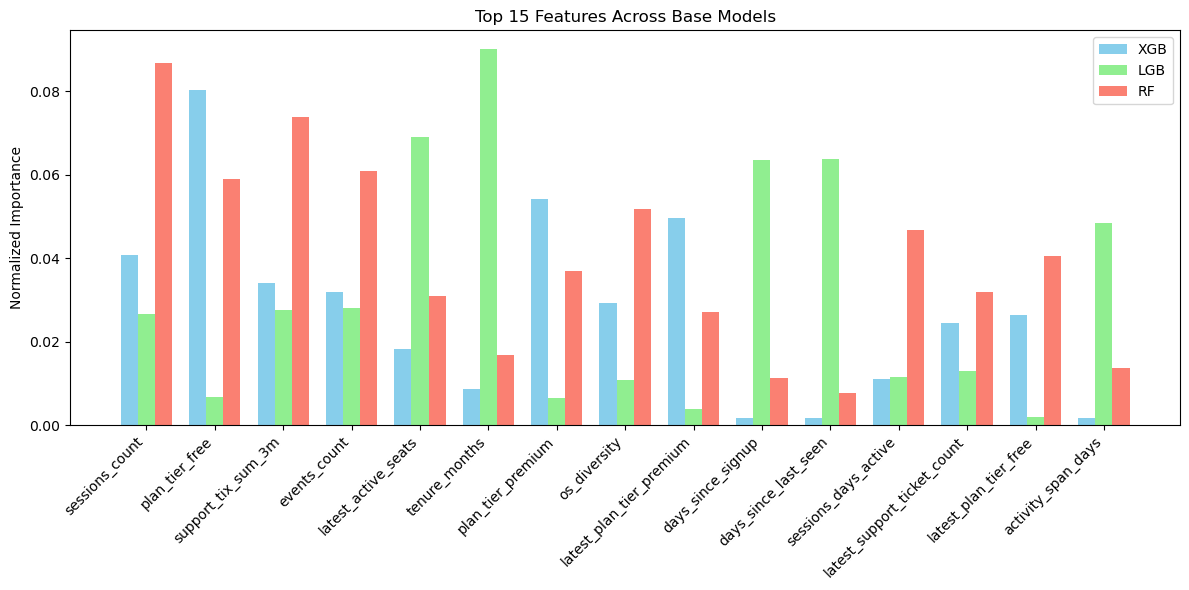

                                  xgb       lgb        rf  mean_importance
sessions_count               0.040680  0.026500  0.086686         0.051289
plan_tier_free               0.080191  0.006667  0.058862         0.048573
support_tix_sum_3m           0.034106  0.027667  0.073839         0.045204
events_count                 0.031793  0.028083  0.060762         0.040213
latest_active_seats          0.018148  0.069083  0.030908         0.039380
tenure_months                0.008537  0.090083  0.016676         0.038432
plan_tier_premium            0.054206  0.006500  0.037032         0.032579
os_diversity                 0.029218  0.010833  0.051762         0.030604
latest_plan_tier_premium     0.049612  0.003833  0.027022         0.026822
days_since_signup            0.001741  0.063583  0.011354         0.025559
days_since_last_seen         0.001723  0.063750  0.007666         0.024380
sessions_days_active         0.011064  0.011583  0.046779         0.023142
latest_support_ticket_cou

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Collect feature names
num_features = numeric_cols
cat_features = preprocessor.named_transformers_['cat'].named_steps['ohe'].get_feature_names_out(categorical_cols)
all_features = np.concatenate([num_features, cat_features])

# Function to extract and normalize feature importances
def get_importances(model, feature_names):
    if hasattr(model, "feature_importances_"):
        imp = pd.Series(model.feature_importances_, index=feature_names)
        return imp / imp.sum()  # normalize to sum = 1
    return pd.Series(0, index=feature_names)

# Get feature importances from base models
base_model_names = ['xgb', 'lgb', 'rf']
importances_df = pd.DataFrame(index=all_features)

for name in base_model_names:
    model = stack_clf.named_estimators_[name]
    importances_df[name] = get_importances(model, all_features)

# Compute average importance across models
importances_df['mean_importance'] = importances_df[base_model_names].mean(axis=1)
top_n = 15
top_features = importances_df.sort_values('mean_importance', ascending=False).head(top_n)

# Plot grouped bar chart
fig, ax = plt.subplots(figsize=(12,6))
bar_width = 0.25
indices = np.arange(len(top_features))

ax.bar(indices - bar_width, top_features['xgb'], width=bar_width, label='XGB', color='skyblue')
ax.bar(indices, top_features['lgb'], width=bar_width, label='LGB', color='lightgreen')
ax.bar(indices + bar_width, top_features['rf'], width=bar_width, label='RF', color='salmon')

ax.set_xticks(indices)
ax.set_xticklabels(top_features.index, rotation=45, ha='right')
ax.set_ylabel("Normalized Importance")
ax.set_title(f"Top {top_n} Features Across Base Models")
ax.legend()
plt.tight_layout()
plt.show()

# Display the top features in a table
print(top_features)


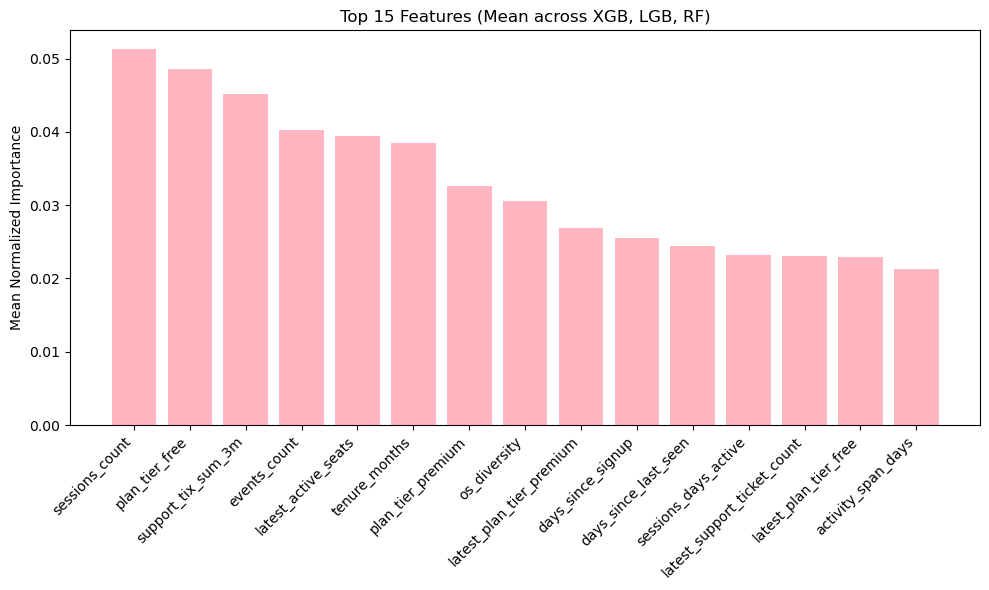

In [15]:

# 4️Plot mean importances only 

fig, ax = plt.subplots(figsize=(10,6))

ax.bar(top_features.index, top_features['mean_importance'], color="#FFB6C1") 

ax.set_ylabel("Mean Normalized Importance")
ax.set_title(f"Top {top_n} Features (Mean across XGB, LGB, RF)")
ax.set_xticks(range(len(top_features)))
ax.set_xticklabels(top_features.index, rotation=45, ha="right")

plt.tight_layout()
plt.show()


/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Top 20 users at risk of churn:
                                    user_id  churn_prob
54582  159c71d8-d3cd-422a-8a78-d406bcea4c76    0.950328
39761  3854d9dc-2c10-4736-bda1-f1b64b307a22    0.923336
59485  f0480516-e296-4804-b9f4-fbec360a4747    0.913504
46421  ced752c3-d124-47b6-bc8f-f373fc66b1a1    0.901995
64512  cb8b8a4e-a92f-44d2-b1c1-6c4d25830c31    0.891894
13405  e972caf5-2ce7-48ef-bca4-f83258898a95    0.879382
22670  278db416-7748-4217-ad66-8abe5b2b1223    0.878697
84629  3baa7589-e122-4958-858f-4bc1050605e1    0.872477
79000  f383c0eb-4dff-444d-8cb5-ae8ed5c50f4d    0.868236
21148  d60fa9d9-41cb-48dd-993e-11ed07478b5f    0.862635
63140  7110b93e-45fd-4dbd-b929-c2759ce172d1    0.858837
33051  1469b673-91e6-4c56-aaa7-0e545f5dcbe2    0.845689
71671  c3ce7bf7-88f1-490e-a38e-6a3817ba18a8    0.844535
46573  69377872-efba-49f6-82a2-456afa220d24    0.820108
37565  8776aa6a-adba-40f0-abaa-2a450aa31c11    0.818905
37508  7a5d190d-e6b0-4301-afa4-e32914b583fb    0.814843
48893  2ec73ff6-e

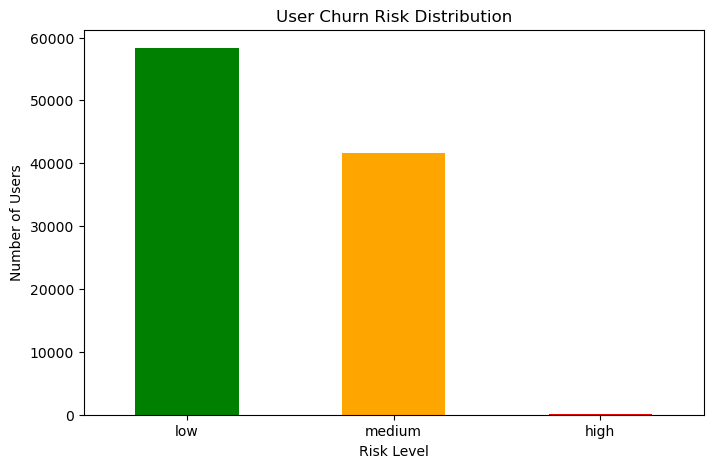

Scoring complete. Saved to user_churn_scores.csv


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Prepare feature set for scoring
X_all = feat.drop(columns=["churned_90d"], errors="ignore")  
X_all_pre = preprocessor.transform(X_all)  

# Predict churn probabilities
churn_prob = stack_clf.predict_proba(X_all_pre)[:, 1]  

# Create DataFrame with user IDs and churn probabilities
user_scores = pd.DataFrame({
    "user_id": X_all.index,   # replace with actual ID column if available
    "churn_prob": churn_prob
})

# Rank users by churn probability
user_scores = user_scores.sort_values("churn_prob", ascending=False)

# View top 20 users at highest risk
print("Top 20 users at risk of churn:")
print(user_scores.head(20))

# Assign risk categories
bins = [0, 0.33, 0.66, 1.0]
labels = ["low", "medium", "high"]
user_scores["risk_level"] = pd.cut(user_scores["churn_prob"], bins=bins, labels=labels)

print("\nRisk level distribution:")
print(user_scores["risk_level"].value_counts())

# Plot churn risk distribution
plt.figure(figsize=(8,5))
user_scores["risk_level"].value_counts().reindex(labels).plot(
    kind='bar', color=['green','orange','red']
)
plt.title("User Churn Risk Distribution")
plt.ylabel("Number of Users")
plt.xlabel("Risk Level")
plt.xticks(rotation=0)
plt.show()

# Save results for further use (e.g., retention campaign)
user_scores.to_csv("user_churn_scores.csv", index=False)
print("Scoring complete. Saved to user_churn_scores.csv")


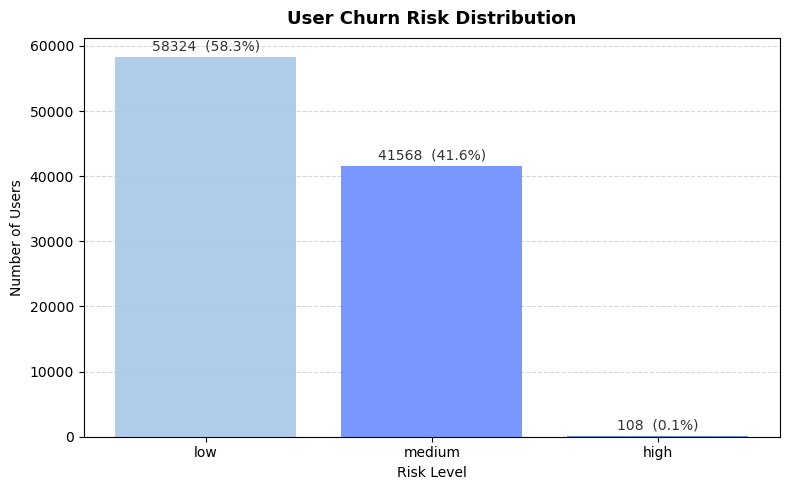

In [17]:

# Risk distribution (clean + labeled)

from matplotlib.ticker import PercentFormatter

# counts & percents in desired order
order = ["low", "medium", "high"]
counts = user_scores["risk_level"].value_counts().reindex(order).fillna(0).astype(int)
percents = (counts / counts.sum()).round(4)

fig, ax = plt.subplots(figsize=(8,5))

bars = ax.bar(order, counts.values, color=["#A7C7E7", "#6A8DFF", "#4A90E2"], alpha=0.9)

# add count + percent labels on top of bars
for bar, n, p in zip(bars, counts.values, percents.values):
    ax.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + max(counts.max()*0.01, 0.5),
        f"{n}  ({p:.1%})",
        ha="center", va="bottom", fontsize=10, color="#333"
    )

ax.set_title("User Churn Risk Distribution", fontsize=13, weight="bold", pad=10)
ax.set_xlabel("Risk Level")
ax.set_ylabel("Number of Users")
ax.yaxis.grid(True, linestyle="--", alpha=0.5)
ax.set_axisbelow(True)
plt.tight_layout()
plt.show()


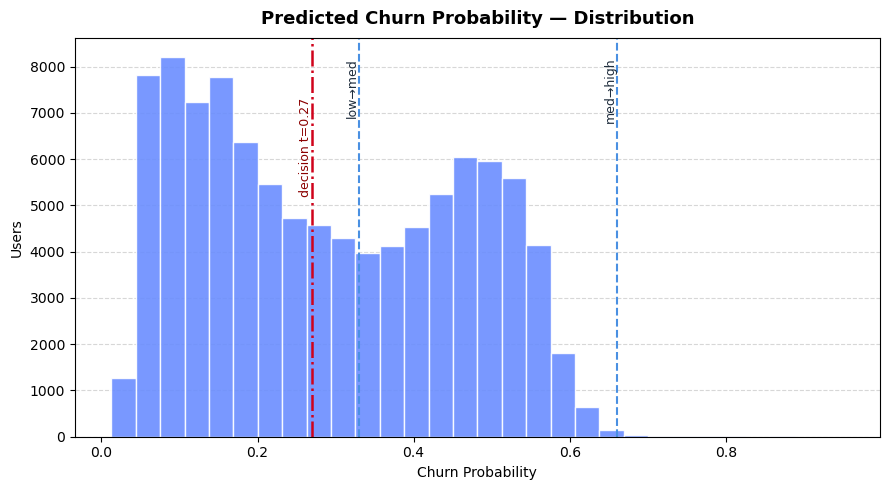

In [18]:

#Churn probability histogram (with cut lines)

fig, ax = plt.subplots(figsize=(9,5))

ax.hist(user_scores["churn_prob"], bins=30, edgecolor="white", alpha=0.9, color="#6A8DFF")
ax.set_title("Predicted Churn Probability — Distribution", fontsize=13, weight="bold", pad=10)
ax.set_xlabel("Churn Probability")
ax.set_ylabel("Users")
ax.yaxis.grid(True, linestyle="--", alpha=0.5)
ax.set_axisbelow(True)

# Show your risk cut points (0.33 / 0.66)
for cut, lbl in [(0.33, "low→med"), (0.66, "med→high")]:
    ax.axvline(cut, linestyle="--", linewidth=1.5, color="#4A90E2")
    ax.text(cut, ax.get_ylim()[1]*0.95, lbl, rotation=90, va="top", ha="right", fontsize=9, color="#1f2d3d")

# If you have a tuned threshold variable (e.g., best_t), annotate it too:
try:
    ax.axvline(best_t, linestyle="-.", linewidth=1.8, color="#D0021B")
    ax.text(best_t, ax.get_ylim()[1]*0.85, f"decision t={best_t:.2f}", rotation=90, va="top", ha="right",
            fontsize=9, color="#8B0000")
except NameError:
    pass

plt.tight_layout()
plt.show()


In [19]:
import numpy as np
import pandas as pd
import shap

# Select high-risk users
high_risk_users = user_scores[user_scores["risk_level"] == "high"].copy()
high_risk_idx = high_risk_users.index.tolist()

# Use the XGB model with SHAP explainer
xgb_model = stack_clf.named_estimators_["xgb"]
explainer = shap.TreeExplainer(xgb_model)

# Preprocessed feature matrix
X_pre = X_all_pre  

# Compute SHAP values
shap_values = explainer(X_pre)  

# Extract values for the positive (churn) class
if isinstance(shap_values.values, list):
    shap_values_pos = shap_values.values[1]  
else:
    shap_values_pos = shap_values.values    

# Collect feature names (numeric + one-hot encoded categorical)
feature_names = numeric_cols + list(
    preprocessor.named_transformers_['cat'].named_steps['ohe'].get_feature_names_out(categorical_cols)
)

# Identify top 3 features per high-risk user
top_features_list = []
for idx in high_risk_idx:
    user_shap = shap_values_pos[idx]  
    top_idx = np.argsort(-np.abs(user_shap))[:3]  
    top_feats = [(feature_names[i], user_shap[i]) for i in top_idx]
    top_features_list.append({
        "user_id": high_risk_users.loc[idx, "user_id"],
        "churn_prob": high_risk_users.loc[idx, "churn_prob"],
        "top_features": top_feats
    })

# Create DataFrame with top drivers for each high-risk user
top_features_df = pd.DataFrame(top_features_list)
top_features_df


,user_id,churn_prob,top_features
0,159c71d8-d3cd-422a-8a78-d406bcea4c76,0.950328,"[(avg_latency, 0.5778472), (support_tix_sum_3m..."
1,3854d9dc-2c10-4736-bda1-f1b64b307a22,0.923336,"[(avg_latency, 0.6278009), (sessions_count, -0..."
2,f0480516-e296-4804-b9f4-fbec360a4747,0.913504,"[(avg_latency, 0.47475645), (features_used, -0..."
3,ced752c3-d124-47b6-bc8f-f373fc66b1a1,0.901995,"[(avg_latency, 0.7576098), (features_used, -0...."
4,cb8b8a4e-a92f-44d2-b1c1-6c4d25830c31,0.891894,"[(avg_latency, 0.8184336), (sessions_count, -0..."
...,...,...,...
103,cc17a604-cac8-4e85-a704-23584cbdfd15,0.661200,"[(sessions_count, 0.24835731), (events_count, ..."
104,84f3d6b5-3009-4a90-b1da-26fa3a5ede86,0.660867,"[(avg_latency, 0.4671282), (sessions_count, -0..."
105,f8c5df45-8513-4288-ab86-3f8116a1f323,0.660619,"[(avg_latency, 0.60124105), (sessions_count, -..."
106,8f68a06b-bd7f-446f-a117-4856e8e64798,0.660536,"[(sessions_count, 0.24605286), (latest_active_..."


In [20]:
from collections import Counter

# Flatten top features
all_top_feats = [feat[0] for row in top_features_df["top_features"] for feat in row]
Counter(all_top_feats).most_common(10)


[('avg_latency', 72),
 ('sessions_count', 53),
 ('features_used', 48),
 ('events_count', 48),
 ('latest_active_seats', 30),
 ('plan_tier_standard', 26),
 ('days_since_last_seen', 19),
 ('support_tix_sum_3m', 12),
 ('tenure_months', 11),
 ('plan_tier_free', 4)]

In [21]:
# Ensure user IDs are strings
user_scores["user_id"] = user_scores["user_id"].astype(str)
users["user_id"] = users["user_id"].astype(str)

# Merge the actual churn labels
user_scores = user_scores.merge(
    users[["user_id", "churned_90d"]],
    on="user_id",
    how="left"
)

# Filter high-risk users
high_risk_users = user_scores[user_scores["risk_level"]=="high"]
print(high_risk_users[["user_id", "churn_prob", "churned_90d"]])


                                  user_id  churn_prob  churned_90d
0    159c71d8-d3cd-422a-8a78-d406bcea4c76    0.950328            1
1    3854d9dc-2c10-4736-bda1-f1b64b307a22    0.923336            1
2    f0480516-e296-4804-b9f4-fbec360a4747    0.913504            0
3    ced752c3-d124-47b6-bc8f-f373fc66b1a1    0.901995            1
4    cb8b8a4e-a92f-44d2-b1c1-6c4d25830c31    0.891894            1
..                                    ...         ...          ...
103  cc17a604-cac8-4e85-a704-23584cbdfd15    0.661200            1
104  84f3d6b5-3009-4a90-b1da-26fa3a5ede86    0.660867            1
105  f8c5df45-8513-4288-ab86-3f8116a1f323    0.660619            1
106  8f68a06b-bd7f-446f-a117-4856e8e64798    0.660536            1
107  6f1892fa-7987-4951-aae3-e0746e07e03b    0.660074            1

[108 rows x 3 columns]


In [22]:
# High-risk users
high_risk_users = user_scores[user_scores["risk_level"] == "high"]

# Compute accuracy: proportion of correctly predicted churners
# Here "correct" means user predicted high-risk and actually churned
accuracy_high_risk = high_risk_users["churned_90d"].mean()

print(f"Number of high-risk users: {len(high_risk_users)}")
print(f"Accuracy within high-risk users: {accuracy_high_risk:.4f} ({accuracy_high_risk*100:.2f}%)")


Number of high-risk users: 108
Accuracy within high-risk users: 0.8519 (85.19%)


| Feature                | # of high-risk users affected | Insight                                                                                                 |
| ---------------------- | ----------------------------- | ------------------------------------------------------------------------------------------------------- |
| `avg_latency`          | 70                            | Performance issues are the strongest driver. Users experiencing slow response are more likely to churn. |
| `sessions_count`       | 52                            | Low engagement (fewer sessions) contributes to churn risk.                                              |
| `events_count`         | 49                            | Low usage of features/events increases churn likelihood.                                                |
| `features_used`        | 44                            | Users using fewer features are at higher risk—indicates low product adoption.                           |
| `latest_active_seats`  | 43                            | Users with fewer active seats might not be seeing value; could indicate smaller teams or trial users.   |
| `days_since_last_seen` | 19                            | Users inactive for longer are more likely to churn.                                                     |
| `support_tix_sum_3m`   | 14                            | Users submitting many tickets might be frustrated; need proactive support.                              |
| `plan_tier_standard`   | 13                            | Users on standard plan tier are slightly more at risk than premium.                                     |
| `tenure_months`        | 12                            | Shorter tenure users are more likely to churn.                                                          |
| `plan_tier_free`       | 4                             | Free-tier users are least likely to stick around, but fewer were in high-risk set.                      |

In [23]:
# Helper: extract top-k SHAP drivers per user in a risk band

from collections import Counter

def extract_top_k_for_risk_band(user_scores, risk_label, shap_values_matrix, feature_names, k=3):
    """
    user_scores: DataFrame with columns ["user_id", "churn_prob", "risk_level", ...]
    risk_label: one of {"low","medium","high"}
    shap_values_matrix: ndarray (n_samples, n_features) of SHAP values (probability space)
    feature_names: array-like of length n_features
    k: how many top |SHAP| features to keep per user
    """
    def arrow(v): return "↑" if v > 0 else ("↓" if v < 0 else "•")

    band = user_scores[user_scores["risk_level"] == risk_label].copy()
    idxs = band.index.to_list()

    rows = []
    for idx in idxs:
        contrib = shap_values_matrix[idx]                         # shape: (n_features,)
        top_idx = np.argsort(-np.abs(contrib))[:k]                # indices of top-|SHAP|
        feats = [(feature_names[i], float(contrib[i]), arrow(contrib[i])) for i in top_idx]
        rows.append({
            "user_id": band.loc[idx, "user_id"],
            "churn_prob": float(band.loc[idx, "churn_prob"]),
            "top_features": feats
        })

    df = pd.DataFrame(rows).sort_values("churn_prob", ascending=False).reset_index(drop=True)

    # Also return a quick cohort summary of most frequent top drivers
    flat = [f for row in df["top_features"] for (f, _, _) in row]
    common = Counter(flat).most_common(15)
    summary = pd.DataFrame(common, columns=["feature", "count"])

    return df, summary


In [24]:
# Medium-risk users
medium_risk_users = user_scores[user_scores["risk_level"] == "medium"]

# Precision within medium band (how many actually churned)
accuracy_medium_risk = medium_risk_users["churned_90d"].mean()

print(f"Number of medium-risk users: {len(medium_risk_users)}")
print(f"Accuracy within medium-risk users: {accuracy_medium_risk:.4f} ({accuracy_medium_risk*100:.2f}%)")


Number of medium-risk users: 41568
Accuracy within medium-risk users: 0.3707 (37.07%)


In [25]:
import pandas as pd
import numpy as np

def risk_band_summary(user_scores, label_col="churned_90d"):
    # Overall baseline churn rate
    baseline = user_scores[label_col].mean()

    rows = []
    total_users = len(user_scores)

    for band in ["low", "medium", "high"]:
        band_df = user_scores[user_scores["risk_level"] == band]
        n = len(band_df)
        if n > 0:
            precision = band_df[label_col].mean()
            lift = precision / baseline if baseline > 0 else np.nan
        else:
            precision, lift = np.nan, np.nan

        rows.append({
            "Risk Band": band.capitalize(),
            "Users": n,
            "% of Users": n / total_users * 100,
            "Churn Rate in Band": precision * 100 if not np.isnan(precision) else np.nan,
            "Lift vs Baseline": lift
        })

    return pd.DataFrame(rows)

# Usage
summary_df = risk_band_summary(user_scores)
print(summary_df.to_string(index=False))


Risk Band  Users  % of Users  Churn Rate in Band  Lift vs Baseline
      Low  58324      58.324           12.842055          0.558544
   Medium  41568      41.568           37.071786          1.612378
     High    108       0.108           85.185185          3.704992


In [26]:
def score_probs(raw_df):
    """Transform raw features with your fitted preprocessor and score with the stack."""
    X_pre = preprocessor.transform(raw_df)
    return stack_clf.predict_proba(X_pre)[:, 1]


In [27]:
# Example intervention spec (edit as needed)
INTERVENTIONS = {
    # Numeric features (operate in raw space)
    "avg_latency": {"op": "scale", "factor": 0.8},              # reduce latency by 20%
    "sessions_count": {"op": "add", "delta": 2},                # +2 sessions
    "events_count": {"op": "add", "delta": 10},                 # +10 events
    "features_used": {"op": "add", "delta": 1},                 # try to get them to try 1 more feature
    "days_since_last_seen": {"op": "set", "value": 1},          # simulate reactivation

    # Categorical change (switch plan tier). Use the RAW column name.
    # If you want to target the billing one, use "latest_plan_tier" instead.
    "plan_tier": {"op": "set", "value": "premium"}              # move to premium tier
}


In [28]:
# Example intervention spec (edit as needed)
INTERVENTIONS = {
    # Numeric features (operate in raw space)
    "avg_latency": {"op": "scale", "factor": 0.8},              # reduce latency by 20%
    "sessions_count": {"op": "add", "delta": 2},                # +2 sessions
    "features_used": {"op": "add", "delta": 1},                 # try to get them to try 1 more feature
}


In [29]:
import numpy as np
import pandas as pd

def apply_interventions(X_raw, spec, clip_nonnegative=True):
    """Return a COPY of X_raw with interventions applied according to spec."""
    X_new = X_raw.copy()
    for col, rule in spec.items():
        if col not in X_new.columns:
            # silently skip if column absent
            continue
        op = rule.get("op")
        if op == "scale":
            factor = rule.get("factor", 1.0)
            X_new[col] = X_new[col] * factor
        elif op == "add":
            delta = rule.get("delta", 0.0)
            X_new[col] = X_new[col] + delta
        elif op == "set":
            value = rule.get("value")
            X_new[col] = value
        # safety: keep sensible bounds for counts/latencies
        if clip_nonnegative and np.issubdtype(X_new[col].dtype, np.number):
            X_new[col] = X_new[col].clip(lower=0)
    return X_new

def what_if(user_scores, risk_label, interventions, top_n=20):
    """
    Run a what-if on a given risk band.
    Returns a DataFrame with old/new probs and deltas, sorted by largest improvement.
    """
    # pick cohort
    cohort_idx = user_scores[user_scores["risk_level"] == risk_label].index
    if len(cohort_idx) == 0:
        return pd.DataFrame()

    # raw features for cohort
    X_raw = feat.drop(columns=["churned_90d"], errors="ignore").iloc[cohort_idx]

    # score before
    p_before = score_probs(X_raw)

    # apply interventions and rescore
    X_after = apply_interventions(X_raw, interventions)
    p_after = score_probs(X_after)

    out = pd.DataFrame({
        "user_id": user_scores.loc[cohort_idx, "user_id"].astype(str).values,
        "prob_before": p_before,
        "prob_after": p_after,
        "delta": p_after - p_before
    }, index=cohort_idx).sort_values("delta")  # most negative (improvement) first

    # optional: show top-N biggest improvements
    return out.head(top_n)


In [30]:
def score_probs(X_raw: pd.DataFrame) -> np.ndarray:
    """Predict with consistent feature names so LGBM/RF don't warn."""
    Xp = preprocessor.transform(X_raw)  # -> numpy array

    # Get the exact feature names the model was trained with
    try:
        cols = list(preprocessor.get_feature_names_out())
    except AttributeError:
        # Fallback if get_feature_names_out() isn't available
        ohe_fitted = preprocessor.named_transformers_['cat'].named_steps['ohe']
        cat_names = list(ohe_fitted.get_feature_names_out(categorical_cols))
        cols = list(numeric_cols) + cat_names

    Xp_df = pd.DataFrame(Xp, columns=cols, index=X_raw.index)
    return stack_clf.predict_proba(Xp_df)[:, 1]


# Example: run on MEDIUM risk users
medium_whatif = what_if(user_scores, "medium", INTERVENTIONS, top_n=25)
print(medium_whatif.to_string(index=False))

# Quick aggregates for the cohort
if len(medium_whatif) > 0:
    # compute aggregates on full cohort to summarize effect
    cohort_idx = user_scores[user_scores["risk_level"] == "medium"].index
    X_raw = feat.drop(columns=["churned_90d"], errors="ignore").iloc[cohort_idx]
    p_before = score_probs(X_raw)
    p_after  = score_probs(apply_interventions(X_raw, INTERVENTIONS))
    print("\n=== Cohort summary (medium) ===")
    print(f"Mean prob before: {p_before.mean():.4f}")
    print(f"Mean prob after : {p_after.mean():.4f}")
    print(f"Average change  : {(p_after - p_before).mean():+.4f}")
    # How many cross a target threshold (e.g., 0.33)?
    target = 0.33
    improved = ((p_before >= target) & (p_after < target)).sum()
    total = len(p_before)
    print(f"Users moved below {target:.2f}: {improved}/{total} ({improved/total:.1%})")


                             user_id  prob_before  prob_after     delta
cede1ca6-d29e-4201-b2c4-8d14215c1925     0.627467    0.326202 -0.301265
f3185314-6799-44ac-abe4-d838da9d5f0a     0.612486    0.317795 -0.294691
a9d2e58c-a580-4c0d-bd0f-72f573171da7     0.626256    0.332077 -0.294179
98fd04e8-ac72-40cc-93f5-6393cbb3040f     0.618144    0.326710 -0.291434
741f0966-5bf3-4026-83e4-bf03645a5a4d     0.612464    0.322121 -0.290344
6ccaa07e-3c5d-4b50-b38d-bee33a2cb693     0.555014    0.264804 -0.290210
518e020b-af39-4632-994e-a9214128078f     0.610733    0.320615 -0.290118
bd98da59-19bb-484f-a095-a87cb2d37fe2     0.551705    0.262297 -0.289408
28e5b046-4056-4848-9797-a40ad51b4d90     0.513287    0.227122 -0.286166
ce9ffff8-0d39-4261-92f9-3e1a59f8ea1a     0.538441    0.252627 -0.285814
5938b8ad-110c-49f4-95c2-1b426a54fe97     0.579381    0.294281 -0.285100
bf7e0be4-afcd-428f-bdd5-530d25f0a3f0     0.560073    0.275138 -0.284934
466dc504-e2e0-4b6e-bee9-5727867ccd7f     0.547213    0.262530 -0

In [31]:
# Suppose your what_if results are stored in medium_whatif
print("Average prob_before:", medium_whatif["prob_before"].mean())
print("Average prob_after :", medium_whatif["prob_after"].mean())
print("Average delta      :", medium_whatif["delta"].mean())


Average prob_before: 0.5759019807471156
Average prob_after : 0.28975937357726217
Average delta      : -0.2861426071698535


In [32]:
import numpy as np
import pandas as pd

def sweep_scale(feature, scales, band="medium", target=0.33):
    """
    For users in `band`, scale a numeric `feature` by each factor in `scales`
    (e.g., 0.9= -10%, 0.8= -20%), rescore, and report impact.
    """
    idx = user_scores[user_scores["risk_level"] == band].index
    X_raw = feat.drop(columns=["churned_90d"], errors="ignore").iloc[idx]
    p0 = score_probs(X_raw)

    rows = []
    for s in scales:
        spec = {feature: {"op": "scale", "factor": float(s)}}
        X_after = apply_interventions(X_raw, spec)
        p1 = score_probs(X_after)
        delta = p1 - p0
        moved = ((p0 >= target) & (p1 < target)).sum()
        rows.append({
            "feature": feature,
            "scale_factor": s,
            "mean_prob_before": p0.mean(),
            "mean_prob_after": p1.mean(),
            "avg_change": delta.mean(),     # negative is good
            "median_change": np.median(delta),
            "p95_worst": np.quantile(delta, 0.95),
            "users_moved_below_target": int(moved),
            "band_users": len(p0)
        })
    return pd.DataFrame(rows).sort_values("scale_factor")


In [33]:
scales = [1.00, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7]
latency_sweep_med = sweep_scale("avg_latency", scales, band="medium", target=0.33)
print(latency_sweep_med.to_string(index=False))


    feature  scale_factor  mean_prob_before  mean_prob_after    avg_change  median_change  p95_worst  users_moved_below_target  band_users
avg_latency          0.70           0.29135         0.287571 -3.778969e-03  -5.551115e-17   0.002215                       396       41568
avg_latency          0.75           0.29135         0.288108 -3.242624e-03  -5.551115e-17   0.001732                       342       41568
avg_latency          0.80           0.29135         0.288696 -2.654333e-03  -1.110223e-16   0.001466                       276       41568
avg_latency          0.85           0.29135         0.289293 -2.057323e-03  -2.220446e-16   0.001118                       215       41568
avg_latency          0.90           0.29135         0.289953 -1.397280e-03  -6.062033e-05   0.000709                       150       41568
avg_latency          0.95           0.29135         0.290638 -7.124166e-04  -9.050465e-05   0.000164                        89       41568
avg_latency          1.00  

In [34]:
def sweep_add(feature, deltas, band="medium", target=0.33):
    idx = user_scores[user_scores["risk_level"] == band].index
    X_raw = feat.drop(columns=["churned_90d"], errors="ignore").iloc[idx]
    p0 = score_probs(X_raw)

    rows = []
    for d in deltas:
        spec = {feature: {"op": "add", "delta": float(d)}}
        X_after = apply_interventions(X_raw, spec)
        p1 = score_probs(X_after)
        delta = p1 - p0
        moved = ((p0 >= target) & (p1 < target)).sum()
        rows.append({
            "feature": feature,
            "add_delta": d,
            "mean_prob_before": p0.mean(),
            "mean_prob_after": p1.mean(),
            "avg_change": delta.mean(),
            "median_change": np.median(delta),
            "p95_worst": np.quantile(delta, 0.95),
            "users_moved_below_target": int(moved),
            "band_users": len(p0)
        })
    return pd.DataFrame(rows).sort_values("add_delta")


In [35]:
sessions_sweep_med = sweep_add("sessions_count", [0,1,2,3,5,10], band="medium", target=0.33)
events_sweep_med   = sweep_add("events_count",   [0,5,10,20,40],  band="medium", target=0.33)
print(sessions_sweep_med.to_string(index=False))
print(events_sweep_med.to_string(index=False))


       feature  add_delta  mean_prob_before  mean_prob_after    avg_change  median_change  p95_worst  users_moved_below_target  band_users
sessions_count          0           0.29135         0.291350  5.438538e-19       0.000000   0.000000                         0       41568
sessions_count          1           0.29135         0.327238  3.588798e-02       0.004969   0.187251                      1810       41568
sessions_count          2           0.29135         0.253584 -3.776589e-02      -0.002176   0.017904                      5419       41568
sessions_count          3           0.29135         0.241216 -5.013443e-02      -0.001214   0.027250                      7622       41568
sessions_count          5           0.29135         0.254214 -3.713635e-02       0.013782   0.047972                      7015       41568
sessions_count         10           0.29135         0.297730  6.380158e-03       0.038881   0.098980                      3832       41568
     feature  add_delta  me

Exception ignored in: <function ResourceTracker.__del__ at 0x1072bdbc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x103139bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x108b35bc0>
Traceback (most recent call last